In [326]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [327]:
pred = pd.read_csv('/Users/mjin/Desktop/1008/Project/DeepLearning2020/saved/dl2020/dl2020_0430-162145_coef0/evaluation_result_best-efficientdet-d0_11970_val_132_133_0.05_0.1.csv')

In [330]:
truth = pd.read_csv('datasets/dl2020/annotation_newfeat_2.csv')

In [331]:
pred['x_pred'], pred['y_pred'], pred['w_pred'], pred['h_pred'] = [float(i.split(',')[0][1:]) for i in pred['bbox']], [float(i.split(',')[1]) for i in pred['bbox']], [float(i.split(',')[2]) for i in pred['bbox']], [float(i.split(',')[3][:-1]) for i in pred['bbox']]

pred['box_width'] = pred['w_pred']/612*80
pred['box_height'] = pred['h_pred']/768*80

pred['center_x'] = pred['x_pred']/612*80 + pred['box_width']/2 - 40
pred['center_y'] = 40 - pred['y_pred']/768*80 - pred['box_height']/2


In [344]:
pred_sample = pred[pred['scene_id'] == 132][pred['sample_id'] == 0]

/Users/mjin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [345]:
truth_sample = truth[truth['scene'] == 132][truth['sample'] == 0]

/Users/mjin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


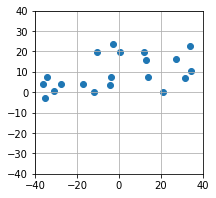

In [346]:
plt.figure(figsize = (3,3))
plt.scatter(truth_sample['center_x'], truth_sample['center_y'])
plt.xlim(-40, 40)
plt.ylim(-40, 40)
plt.grid()

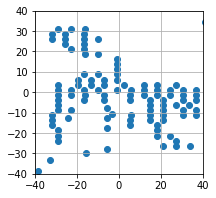

In [347]:
plt.figure(figsize = (3,3))
plt.scatter(pred_sample['center_x'], pred_sample['center_y'])
plt.xlim(-40, 40)
plt.ylim(-40, 40)
plt.grid()

In [309]:
pred.shape

(25283, 14)

In [310]:
import torch

In [337]:
def calc_iou(pred, truth):
    # pred (x, y, w, h)
    # truth (x, y, w, h)
    
    area_pred = pred[2]*pred[3]
    area_truth = truth[2]*truth[3]
    
    inter_width = min(pred[0] + pred[2]/2, truth[0] + truth[2]/2) - max(pred[0] - pred[2]/2, truth[0] - truth[2]/2)
    inter_height = min(pred[1] + pred[3]/2, truth[1] + truth[3]/2) - max(pred[1] - pred[3]/2, truth[1] - truth[3]/2)
    
    inter_width = max(inter_width,0)
    inter_height = max(inter_height, 0)
    
    area_inter = inter_width*inter_height
    area_union = area_pred + area_truth - area_inter
    
    IoU = area_inter / area_union

    return IoU

In [338]:
def calc_metric(truth_sample, pred_sample):
    result_lst = []
    truth_num = len(truth_sample)
    pred_num = len(pred_sample)
    
    for iou in [0.5,0.6,0.7,0.8,0.9]:
        pred_sample_copy = pred_sample.copy()
        tp = 0
        fp = 0
        for row_t in truth_sample_copy.iterrows():
            found = False
            truth_box = [row_t[1]['center_x'], row_t[1]['center_y'], row_t[1]['box_width'], row_t[1]['box_height']]
            for row_p in pred_sample.iterrows():
                pred_box = [row_p[1]['center_x'], row_p[1]['center_y'], row_p[1]['box_width'], row_p[1]['box_height']]
                if calc_iou(pred_box, truth_box) >= iou:
                    found = True
                    pred_sample_copy = pred_sample_copy.drop(row_p[0])
            if found == True:
                tp += 1
        fp = len(pred_sample_copy)
        result_lst.append(tp/(truth_num + fp))
    
    return result_lst, np.mean(result_lst)
            
            

In [339]:
calc_metric(truth_sample, pred_sample)

([0.0, 0.0, 0.0, 0.0, 0.0], 0.0)

In [314]:
result = []
for scene in [132]:
    for sample in range(30):
        pred_sample = pred[pred['scene_id'] == 132][pred['sample_id'] == sample]
        truth_sample = truth[truth['scene'] == 132][truth['sample'] == sample]
        
        result.append(calc_metric(truth_sample, pred_sample)[1])
        
print(np.mean(result))

/Users/mjin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
/Users/mjin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


0.0015438910983276613


In [340]:
pred_sample.head()

,Unnamed: 0,scene_id,sample_id,category_id,score,bbox,x_pred,y_pred,w_pred,h_pred,box_width,box_height,center_x,center_y
10693,10693,132.0,100.0,3.0,0.073484,"[751.7706909179688, 1.051850438117981, 14.7293...",751.770691,1.051850,14.729309,9.579486,1.925400,0.997863,59.233378,39.391501
10694,10694,132.0,100.0,3.0,0.072274,"[281.6029357910156, 385.664794921875, 37.45037...",281.602936,385.664795,37.450378,19.373749,4.895474,2.018099,-0.741422,-1.182466
10695,10695,132.0,100.0,3.0,0.067501,"[378.64874267578125, 362.82720947265625, 35.29...",378.648743,362.827209,35.299164,19.002899,4.614270,1.979469,11.803703,1.215765
10696,10696,132.0,100.0,3.0,0.065035,"[234.91773986816406, 363.0290222167969, 35.154...",234.917740,363.029022,35.154037,18.769318,4.595299,1.955137,-6.994149,1.206908
10697,10697,132.0,100.0,3.0,0.064857,"[378.5469055175781, 386.3060607910156, 36.1821...",378.546906,386.306061,36.182129,19.879395,4.729690,2.070770,11.848101,-1.275600


In [341]:
truth_sample.head()

,Unnamed: 0,scene,sample,action,category,fl_x,fr_x,bl_x,br_x,fl_y,...,back_right,distance,center_x,center_y,box_width,box_height,scaled_x,scaled_y,scaled_box_width,scaled_box_height
40687,40687,132,100,object_action_parked,car,-23.150282,-21.393209,-23.006398,-21.249325,-8.555356,...,True,24.661708,-22.199804,-10.740975,1.900957,4.485343,128.900341,465.583716,14.542323,43.059293
40688,40688,132,100,object_action_parked,car,-34.050107,-32.215612,-33.211502,-31.377008,-9.000946,...,False,34.594944,-32.713557,-11.253147,2.673099,5.141929,45.516685,467.348954,20.449204,49.362518
40689,40689,132,100,object_action_parked,car,1.260087,3.303538,1.507806,3.551257,-8.507711,...,False,11.196316,2.405672,-10.934817,2.291170,5.058345,315.639669,464.694188,17.527447,48.560111
40690,40690,132,100,object_action_parked,car,20.281579,20.233797,25.539978,25.492196,25.135861,...,False,34.765015,22.886888,26.168619,5.306181,2.065516,460.788546,122.866778,40.592288,19.828955
40691,40691,132,100,object_action_parked,car,-16.486788,-14.586164,-16.574375,-14.673751,-8.721109,...,True,19.038064,-15.580270,-10.940890,1.988211,4.439562,179.206031,467.722648,15.209815,42.619792


(array([ 1.,  0.,  0., 33.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6, 4.2, 4.8, 5.4, 6. ]),
 <a list of 10 Patch objects>)

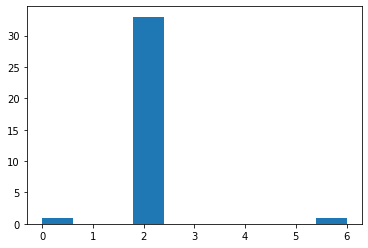

In [288]:
plt.hist(truth_sample.category_id)

(array([  1.,   0.,   0., 121.,   0.,   0.,   2.,   0.,   0.,   1.]),
 array([1. , 1.3, 1.6, 1.9, 2.2, 2.5, 2.8, 3.1, 3.4, 3.7, 4. ]),
 <a list of 10 Patch objects>)

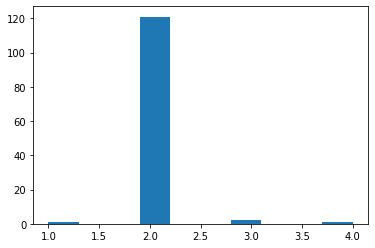

In [315]:
plt.hist(pred_sample.category_id)

In [316]:
from collections import Counter

In [317]:
Counter(pred.category_id)

Counter({2.0: 24274, 3.0: 501, 1.0: 252, 4.0: 247, 8.0: 9})

In [320]:
import matplotlib.patches as patches

In [325]:
color_list = ['b', 'g', 'orange', 'c', 'm', 'y', 'k', 'w', 'r']

In [351]:
def plot_boxes(df):
    fig,ax = plt.subplots(figsize=(10,10))
    ax.scatter(0, 0, marker = 'x', c = 'r')
    ax.set_xlim(-40, 40)
    ax.set_ylim(-40, 40)
    for index, row in df.iterrows():
        x = row['center_x']
        y = row['center_y']
        w = row['box_width']
        h = row['box_height']
        c_id = int(row['category_id'])
        rect = patches.Rectangle((x,y),w,h,linewidth=1,edgecolor=color_list[c_id],facecolor='none')
        ax.add_patch(rect)
    plt.grid()
    plt.show()

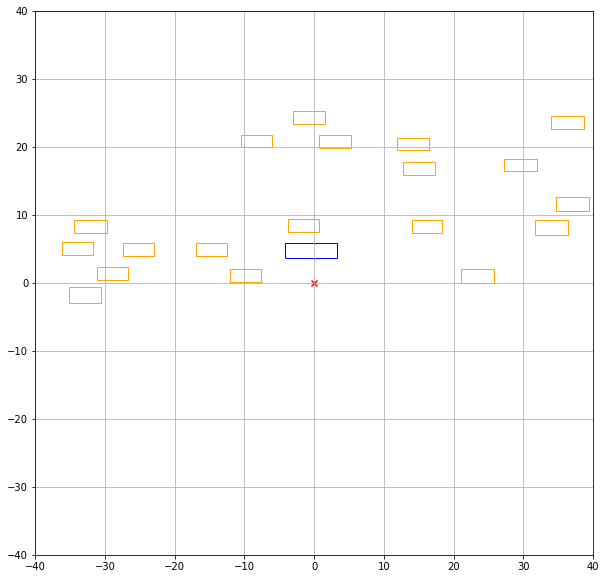

In [352]:
plot_boxes(truth_sample)

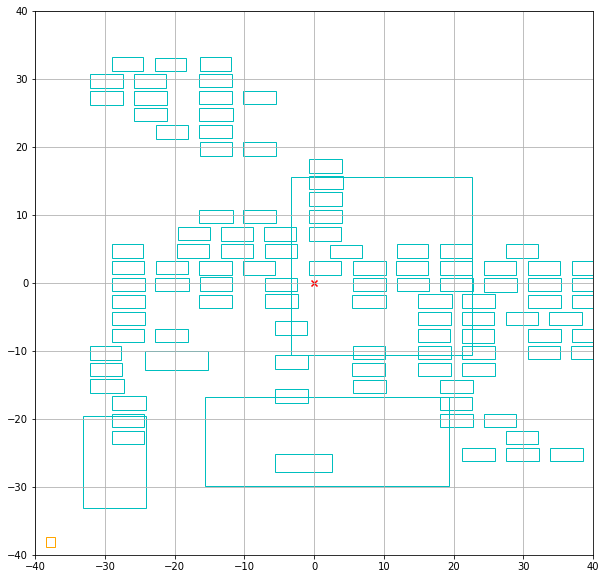

In [353]:
plot_boxes(pred_sample)